In [1]:
import sys

sys.path.append("../..")

from sqlalchemy import func

from inspect import getmembers
import os
import pandas as pd
from shapely.geometry import Polygon
from src.models import *
from src import crud
from src.pingers import *
from src.database.session import db
from src.image_analysis.rekognition.utils import *
from src.image_analysis.relevant_uuids import text_uuids, face_uuids
from src.utils import *
from src.s3.image import s3_image
import boto3
from tqdm import tqdm
import random
import uuid

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sanjinjuricfot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjinjuricfot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-05-09 15:44:36.517 | DEBUG    | src.database.session:<module>:17 - base: prod.cw6tznt1p9hq.us-east-1.rds.amazonaws.com


In [7]:
# df = read_csv_from_s3('data/fb_images/rekognition/sample_uuids.csv')
table_path = 'data/fb_images/rekognition/image.csv'
global_image_folder = 'data/fb_images/images'
max_labels = 5
# df['text'] = None
# df['labels'] = None
# df['faces'] = None

In [3]:
df = read_csv_from_s3(table_path)

In [6]:
df

,uuid,text,labels,faces
0,91b58b5c-eb37-11ed-bdfc-66c93374e280,[{}],"[{'name': 'Cup', 'parents': []}]",[]
1,9e44c07c-eb37-11ed-bdfc-66c93374e280,"[{'text': 'SDA\nGANIC', 'height': 0.0634765028...","[{'name': 'T-Shirt', 'parents': [{'Name': 'Clo...","[{'width': 0.06132263317704201, 'age': '22 - 3..."
2,d2ff8f68-eb37-11ed-bdfc-66c93374e280,"[{'text': 'HOW DO YOU\n#GOFORBOLD?', 'height':...","[{'name': 'Collage', 'parents': [{'Name': 'Art...","[{'width': 0.05306684598326683, 'age': '33 - 4..."
3,3574eef0-eb37-11ed-bdfc-66c93374e280,[{}],"[{'name': 'Dress', 'parents': [{'Name': 'Cloth...","[{'width': 0.08878457546234131, 'age': '18 - 2..."
4,61fafdde-eb37-11ed-bdfc-66c93374e280,[{}],"[{'name': 'T-Shirt', 'parents': [{'Name': 'Clo...","[{'width': 0.1512179970741272, 'age': '24 - 34..."
...,...,...,...,...
86,32d93614-eb38-11ed-bdfc-66c93374e280,NaN,NaN,NaN
87,0403fd38-eb38-11ed-bdfc-66c93374e280,NaN,NaN,NaN
88,8ff38cb4-eb38-11ed-bdfc-66c93374e280,NaN,NaN,NaN
89,847fbbd8-eb37-11ed-bdfc-66c93374e280,NaN,NaN,NaN


In [9]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    if type(row['labels']) == list:
        continue 
    image = MyRekognitionImage(path=f'{global_image_folder}/{row["uuid"]}.png')
    row['text'] = [image.get_text()]
    row['labels'] = image.get_labels(max_labels=max_labels)
    row['faces'] = image.get_faces()
    if idx % 5 == 2:
        save_csv_to_s3(df=df, path=table_path, index=False)
save_csv_to_s3(df=df, path=table_path, index=False)

100%|██████████| 91/91 [01:48<00:00,  1.19s/it]


In [62]:
df.loc[idx, 'text']

[{}]

In [63]:
df.loc[idx, 'labels']

[{'name': 'T-Shirt', 'parents': [{'Name': 'Clothing'}]},
 {'name': 'Spoke', 'parents': [{'Name': 'Machine'}]},
 {'name': 'Adult', 'parents': [{'Name': 'Person'}]},
 {'name': 'Man',
  'parents': [{'Name': 'Adult'}, {'Name': 'Male'}, {'Name': 'Person'}]},
 {'name': 'Person', 'parents': []}]

In [64]:
df.loc[idx, 'faces']

[]

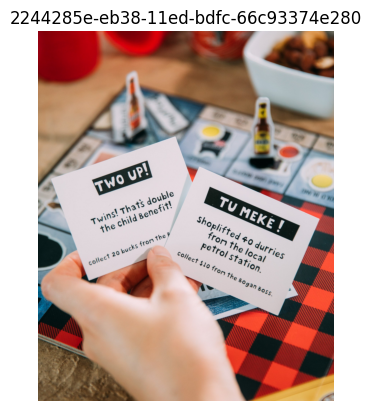

In [7]:
image = MyRekognitionImage(path=f'{global_image_folder}/{df.loc[idx, "uuid"]}.png')
image.plot()

In [44]:
texts = image.detect_text()

In [45]:
df = pd.DataFrame(texts)
df["geometrical_features"] = df["geometry"].apply(geometrical_analysis)
geometrical_features = df.geometrical_features.apply(pd.Series)
geometrical_columns = geometrical_features.columns.tolist()
df = df.join(geometrical_features)
df = df[(df.kind == "LINE")&(df.confidence > 90)&(df.height > 0.01)]

In [46]:
df

,text,kind,geometry,confidence,geometrical_features,width,height,left,top,center,area,tg,w,e,s,n
0,Harry Potter,LINE,"{'BoundingBox': {'Width': 0.3203125, 'Height':...",99.619377,"{'width': 0.3203125, 'height': 0.1103515625, '...",0.320312,0.110352,0.126953,0.151367,"[0.287109375, 0.20654296875]",0.035347,0.000000,0.126953,0.447266,0.261719,0.151367
1,UP TO OFF,LINE,"{'BoundingBox': {'Width': 0.2587890625, 'Heigh...",99.356781,"{'width': 0.2587890625, 'height': 0.02734375, ...",0.258789,0.027344,0.125977,0.588867,"[0.25537109375, 0.6025390625]",0.007076,0.000000,0.125977,0.384766,0.616211,0.588867
2,SALE 50% HARRY POTTER PRODUCTS,LINE,"{'BoundingBox': {'Width': 0.7480467557907104, ...",98.094315,"{'width': 0.7480467557907104, 'height': 0.4462...",0.748047,0.446289,0.175781,0.180664,"[0.5498045682907104, 0.4038085415959358]",0.333845,0.000000,0.175781,0.923828,0.626953,0.180664
3,CHVÁTIL,LINE,"{'BoundingBox': {'Width': 0.0400390625, 'Heigh...",98.458931,"{'width': 0.0400390625, 'height': 0.0126953125...",0.040039,0.012695,0.849609,0.654297,"[0.86962890625, 0.66064453125]",0.000508,0.000000,0.849609,0.889648,0.666992,0.654297
5,CODENAMES,LINE,"{'BoundingBox': {'Width': 0.2021484375, 'Heigh...",100.000000,"{'width': 0.2021484375, 'height': 0.033203125,...",0.202148,0.033203,0.751953,0.673828,"[0.85302734375, 0.6904296875]",0.006712,0.000000,0.751953,0.954102,0.707031,0.673828
7,SECRET,LINE,"{'BoundingBox': {'Width': 0.025390625, 'Height...",96.732834,"{'width': 0.025390625, 'height': 0.01171875, '...",0.025391,0.011719,0.924805,0.730469,"[0.9375, 0.736328125]",0.000298,0.000000,0.924805,0.950195,0.742188,0.730469
8,1000,LINE,{'BoundingBox': {'Width': 0.048238374292850494...,98.605751,"{'width': 0.048238374292850494, 'height': 0.03...",0.048238,0.034558,0.020119,0.718463,"[0.04423828097060323, 0.7357421964406967]",0.001667,-0.332655,0.020119,0.068357,0.753021,0.718463
9,CO-OP,LINE,"{'BoundingBox': {'Width': 0.0224609375, 'Heigh...",96.223175,"{'width': 0.0224609375, 'height': 0.01171875, ...",0.022461,0.011719,0.925781,0.741211,"[0.93701171875, 0.7470703125]",0.000263,0.000000,0.925781,0.948242,0.752930,0.741211
11,TOP,LINE,"{'BoundingBox': {'Width': 0.06303001195192337,...",94.998398,"{'width': 0.06303001195192337, 'height': 0.032...",0.063030,0.032948,0.280377,0.766226,"[0.31189151853322983, 0.7826999127864838]",0.002077,0.124556,0.280377,0.343407,0.799174,0.766226
12,TRIVIAL,LINE,"{'BoundingBox': {'Width': 0.08557840436697006,...",97.063477,"{'width': 0.08557840436697006, 'height': 0.028...",0.085578,0.028191,0.412681,0.763624,"[0.45547064393758774, 0.7777197957038879]",0.002413,-0.160174,0.412681,0.498260,0.791815,0.763624


In [33]:
df = df[df.tg.apply(lambda x: abs(x) < 0.02)]
main_text_height = df.loc[df.area.idxmax(), 'height']
main_text = df[df.height.between(main_text_height*0.7, main_text_height*1.3)]
n, w = main_text[['n', 'w']].min()
s, e = main_text[['s', 'e']].max()
df = df[((df.s < s+0.1)&(df.n > n-0.1))|((df.w > w-0.1)&(df.e < e+0.1))]
df = df[["text"] + geometrical_columns]
height = df.s.max() - df.n.min()
width = df.e.max() - df.w.min()
center = df.center.mean()
text = "\n".join(df.text.tolist())
result = {"text": text, "height": height, "width": width, "center": center}

In [34]:
result

{'text': 'USDA',
 'height': 0.01171875,
 'width': 0.0283203125,
 'center': array([0.39111328, 0.66796875])}

In [13]:
main_text

,text,kind,geometry,confidence,geometrical_features,width,height,left,top,center,area,tg,w,e,s,n
0,and,LINE,"{'BoundingBox': {'Width': 0.0390625, 'Height':...",23.487772,"{'width': 0.0390625, 'height': 0.0101537704467...",0.039062,0.010154,0.737305,0.294459,"[0.7568359375, 0.29953622817993164]",0.000397,0.0,0.737305,0.776367,0.304613,0.294459


In [20]:
n, s, w, e = df.loc[df.height.idxmax(), ['n', 's', 'w', 'e']]
df = df[((df.s < s+0.1)&(df.n > n-0.1))|((df.w > w-0.1)&(df.e < e+0.1))]

In [24]:
df = df[((df.s < s+0.1)&(df.n > n-0.1))|((df.w > w-0.1)&(df.e < e+0.1))]

In [25]:
df

,text,width,height,left,top,center,tg,w,e,s,n
0,TIME TO,0.378906,0.068359,0.520508,0.212891,"[0.7099609375, 0.2470703125]",0.0,0.520508,0.899414,0.212891,0.281250
2,HANDLE,0.379883,0.071289,0.521484,0.307617,"[0.7114256620407104, 0.3432616889476776]",0.0,0.521484,0.901367,0.307617,0.378906
4,OUR,0.206055,0.071289,0.522461,0.404297,"[0.62548828125, 0.43994140625]",0.0,0.522461,0.728516,0.404297,0.475586
11,BEANS,0.306641,0.071289,0.521484,0.500000,"[0.6748045682907104, 0.5356444716453552]",0.0,0.521484,0.828125,0.500000,0.571289
21,15% OFF NOW +,0.388672,0.037109,0.523438,0.639648,"[0.7177734375, 0.658203125]",0.0,0.523438,0.912109,0.639648,0.676758
26,FREE SHIPPING,0.364258,0.036133,0.522461,0.702148,"[0.7045897841453552, 0.7202148139476776]",0.0,0.522461,0.886719,0.702148,0.738281


In [19]:
result

{'text': "TIME TO\nHANDLE\nOUR\nBEANS\nWORLD'S\n15% OFF NOW +\nSTRONGEST\nFREE SHIPPING\nDark Roast\nGROUND",
 'height': 0.5588176846504211,
 'width': 0.7111997157335281,
 'center': array([0.52553663, 0.57330319])}

In [8]:
[text['confidence'] for text in texts]

[53.379356384277344,
 97.65221405029297,
 67.28469848632812,
 97.66853332519531,
 98.39099884033203,
 93.74052429199219,
 98.37713623046875,
 68.56381225585938,
 70.71312713623047,
 39.51472473144531,
 49.45423126220703,
 64.13984680175781,
 94.09437561035156,
 99.33586883544922,
 98.92533111572266,
 97.33080291748047,
 96.01081085205078,
 98.51457214355469,
 91.828857421875,
 52.69511795043945,
 95.75529479980469,
 96.92042541503906,
 22.544933319091797,
 77.67803192138672,
 23.175737380981445,
 62.065792083740234,
 65.63563537597656,
 90.30005645751953,
 86.10298919677734,
 97.18505096435547,
 25.900449752807617,
 70.60606384277344,
 57.69091796875,
 83.5619125366211,
 49.870452880859375,
 51.98753356933594,
 96.6002197265625,
 63.65644454956055,
 10.692377090454102,
 47.56280517578125,
 15.428337097167969,
 46.73643493652344,
 80.82670593261719,
 85.43013000488281,
 98.88853454589844,
 98.12313842773438,
 48.699222564697266,
 51.6429557800293,
 48.97460174560547,
 51.654563903808594

In [6]:
df.loc[1, 'labels']

In [4]:
faces = image.detect_faces(convert_to_dict=True)
series_of_dicts = pd.Series(faces)
df = pd.DataFrame(faces)
geometrical_features = series_of_dicts.apply(geometrical_analysis).apply(pd.Series)
df

/var/folders/6h/6y6l1_fs15v_7pvxzbpv6j6w0000gn/T/ipykernel_90150/2948418436.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_of_dicts = pd.Series(faces)


""


In [11]:
df.name = 'hah'

In [5]:
faces

[]

In [10]:
type(geometrical_features)

pandas.core.series.Series

In [3]:
with open(f'{os.getenv("GLOBAL_PATH_TO_REPO")}/data/bernardo.png', 'rb') as f:
    image_bytes = bytearray(f.read())
    A = MyRekognitionImage(image_bytes=image_bytes)

# with open(f'{os.getenv("GLOBAL_PATH_TO_REPO")}/data/bernardo.png', 'rb') as f:
#     image_bytes = bytearray(f.read())
#     At = MyRekognitionImage(image_bytes=image_bytes)

In [6]:
labels = A.get_faces()

KeyError: 'geometry'

In [ ]:
labels

[{'bounding_box': {'Width': 0.047912780195474625,
   'Height': 0.09786225110292435,
   'Left': 0.8022750616073608,
   'Top': 0.23232585191726685},
  'age': '18 - 26',
  'gender': 'Male',
  'emotions': ['FEAR'],
  'has': ['open eyes', 'open mouth']},
 {'bounding_box': {'Width': 0.0461762398481369,
   'Height': 0.09552047401666641,
   'Left': 0.43179988861083984,
   'Top': 0.2307611107826233},
  'age': '34 - 42',
  'gender': 'Male',
  'emotions': ['FEAR'],
  'has': ['beard', 'open eyes', 'open mouth']},
 {'bounding_box': {'Width': 0.045227814465761185,
   'Height': 0.09439114481210709,
   'Left': 0.18865762650966644,
   'Top': 0.15613454580307007},
  'age': '23 - 33',
  'gender': 'Male',
  'emotions': ['CALM'],
  'has': ['beard', 'open eyes']},
 {'bounding_box': {'Width': 0.04387219250202179,
   'Height': 0.08676259964704514,
   'Left': 0.6185110807418823,
   'Top': 0.12857554852962494},
  'age': '29 - 39',
  'gender': 'Male',
  'emotions': ['ANGRY'],
  'has': ['beard', 'open eyes', 'ope

In [7]:
labels = A.detect_faces()

In [9]:
label = labels[0]
bounding_box = label['bounding_box']

In [11]:
bounding_box

{'Width': 0.047912780195474625,
 'Height': 0.09786225110292435,
 'Left': 0.8022750616073608,
 'Top': 0.23232585191726685}

In [17]:
result = {k.lower(): v for k, v in bounding_box.items()}
result["center"] = np.array((result["left"] + result["width"] / 2, result["top"] + result["height"] / 2))

In [18]:
result['center']

array([0.82623145, 0.28125698])

In [6]:
text

{'text': '', 'height': nan, 'width': nan, 'center': nan}

In [43]:
A.rgb.shape

(440, 700, 3)

In [ ]:
np.array([np.array()])

In [9]:
def geometrical_analysis(geometry: list[dict]):
    polygon = geometry['Polygon']
    bounding_box = geometry['BoundingBox']
    result = {'height': bounding_box['Height'], 'width': bounding_box['Width']}
    nw, ne, se, sw = (np.array((coord['X'], coord["Y"])) for coord in polygon)
    diff = ne-nw
    tg = diff[1] / diff[0]
    result['tg'] = tg
    corners = np.array([nw, ne, se, sw])
    result['center'] = np.mean(corners, axis=0)
    extremes = {'w': np.min(corners[:, 0]), 'e': np.max(corners[:, 0]), 's': np.min(corners[:, 1]), 'n': np.max(corners[:, 1])}
    return result | extremes

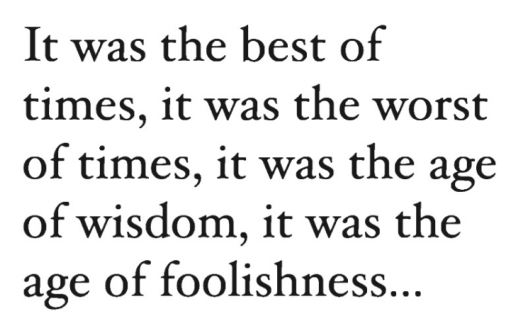

In [38]:
A.plot()

In [7]:
texts = At.detect_text(convert_to_dict=True)
texts

[{'text': 'It was the best of',
  'kind': 'LINE',
  'geometry': {'BoundingBox': {'Width': 0.1220703125,
    'Height': 0.7310824990272522,
    'Left': 0.830078125,
    'Top': 0.02762276865541935},
   'Polygon': [{'X': 0.9521484375, 'Y': 0.02762276865541935},
    {'X': 0.9521484375, 'Y': 0.7587052583694458},
    {'X': 0.830078125, 'Y': 0.7587052583694458},
    {'X': 0.830078125, 'Y': 0.02762276865541935}]},
  'confidence': 100.0},
 {'text': 'times, it was the worst',
  'kind': 'LINE',
  'geometry': {'BoundingBox': {'Width': 0.14997072517871857,
    'Height': 0.9406550526618958,
    'Left': 0.61328125,
    'Top': 0.02332589216530323},
   'Polygon': [{'X': 0.7632519602775574, 'Y': 0.02332589216530323},
    {'X': 0.7632519602775574, 'Y': 0.9639809727668762},
    {'X': 0.61328125, 'Y': 0.9639809727668762},
    {'X': 0.61328125, 'Y': 0.02332589216530323}]},
  'confidence': 99.86943054199219},
 {'text': 'of times, it was the age',
  'kind': 'LINE',
  'geometry': {'BoundingBox': {'Width': 0.160

In [14]:
df = pd.DataFrame(texts)
df['geometrical_features'] = df['geometry'].apply(geometrical_analysis)
geometrical_features = df.geometrical_features.apply(pd.Series)
geometrical_columns = geometrical_features.columns.tolist()
df = df.join(geometrical_features)
df = df[(df.kind == 'LINE') * (df.confidence > 90)]
min_height = min(0.1, df.height.max())
# df = df[(df.height >= min_height)&(df.tg.apply(lambda x: abs(x)<0.2))]
df = df[['text']+geometrical_columns]
height = df.n.max() - df.s.min()
width = df.e.max() - df.w.min()
center = df.center.mean()
text = '\n'.join(df.text.tolist())
result = {
    'text': text,
    'height': height,
    'width': width,
    'center': center
}
result

{'text': 'It was the best of\ntimes, it was the worst\nof times, it was the age\nof wisdom, it was the\nage of foolishness...',
 'height': 0.955747751519084,
 'width': 0.9175988994538784,
 'center': array([0.50164756, 0.45739701])}

In [11]:
df

,text,height,width,tg,center,w,e,s,n


In [66]:
height = df.n.max() - df.s.min()
width = df.e.max() - df.w.min()
center = df.center.mean()
text = '\n'.join(df.text.tolist())
result = {
    'text': text,
    'height': height,
    'width': width,
    'center': center
}
result

{'text': 'It was the best of\ntimes, it was the worst\nof times, it was the age\nof wisdom, it was the\nage of foolishness...',
 'height': 0.918849766254425,
 'width': 0.9553612675517797,
 'center': array([0.45745759, 0.49824021])}

In [45]:
center_x

0    0.392857
1    0.494027
2    0.502427
3    0.466518
4    0.431459
Name: center, dtype: float64

In [32]:
center_x = df.center.apply(lambda x: x[0])
center_y = df.center.apply(lambda x: x[1])
height = center_y.max() - center_y.min()
width = center_x.max() - center_x.min()
center = df.center.mean()
text = '\n'.join(df.text.tolist())
result = {
    'text': text,
    'height': height,
    'width': width,
    'center': center
}

In [23]:
geometrical_columns

Index(['height', 'width', 'tg', 'center'], dtype='object')

In [13]:
geometrical_analysis(text[0]['geometry'])

{'height': 0.125,
 'width': 0.7316964268684387,
 'tg': 0.0,
 'center': array([0.39285715, 0.10742188])}

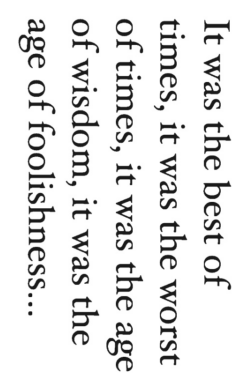

In [36]:
At.plot()

In [44]:
text_t = At.detect_text(convert_to_dict=True)
text_t

[{'text': 'It was the best of',
  'kind': 'LINE',
  'polygon': [{'X': 0.9521484375, 'Y': 0.02762276865541935},
   {'X': 0.9521484375, 'Y': 0.7587052583694458},
   {'X': 0.830078125, 'Y': 0.7587052583694458},
   {'X': 0.830078125, 'Y': 0.02762276865541935}],
  'confidence': 100.0},
 {'text': 'times, it was the worst',
  'kind': 'LINE',
  'polygon': [{'X': 0.7632519602775574, 'Y': 0.02332589216530323},
   {'X': 0.7632519602775574, 'Y': 0.9639809727668762},
   {'X': 0.61328125, 'Y': 0.9639809727668762},
   {'X': 0.61328125, 'Y': 0.02332589216530323}],
  'confidence': 99.86943054199219},
 {'text': 'of times, it was the age',
  'kind': 'LINE',
  'polygon': [{'X': 0.5732421875, 'Y': 0.0245535708963871},
   {'X': 0.5732421875, 'Y': 0.9790736436843872},
   {'X': 0.4130859375, 'Y': 0.9790736436843872},
   {'X': 0.4130859375, 'Y': 0.0245535708963871}],
  'confidence': 99.96050262451172},
 {'text': 'of wisdom, it was the',
  'kind': 'LINE',
  'polygon': [{'X': 0.3946276605129242, 'Y': 0.025781244

In [28]:
save_image_to_s3(image=image, path='data/fb_images/At.png')

In [ ]:
A = RekognitionImage(image_bytes = )

In [2]:
df = pd.read_csv(f'{os.getenv("GLOBAL_PATH_TO_REPO")}/data/url_performance.csv')
urls = df.url.unique()
len(urls)

681

In [3]:
# image_folder = "data/fb_images/images"
# for url in tqdm(urls):
#     image = download_image_from_url(image_url=url)
#     save_image_to_s3(image=image, path=f"{image_folder}/{uuid.uuid1()}.png")

In [10]:
image_folder = "data/fb_images/images"
image_paths = list_objects_from_prefix(prefix=image_folder)
# image_paths = [path for path in image_paths if any([uid in path for uid in text_uuids])]
# image_paths = random.sample(image_paths, 30)
images = []

for path in set(image_paths):
    image = RekognitionImage(path=path, add_global_path=False)
    images.append(image)
i = 0

In [21]:
image_paths = list_objects_from_prefix(prefix=image_folder)
len(image_paths)

674

In [41]:
random_paths = random.sample(image_paths, 50)
random_uuids = [os.path.splitext(os.path.basename(path))[0] for path in random_paths]
uuid_sample = text_uuids + face_uuids
uuid_sample = random_uuids + uuid_sample
uuid_sample = set(uuid_sample)
image_df = pd.DataFrame(uuid_sample, columns=['uuid'])
image_df = image_df[image_df.uuid.apply(len) > 0]
image_df

,uuid
0,91b58b5c-eb37-11ed-bdfc-66c93374e280
1,9e44c07c-eb37-11ed-bdfc-66c93374e280
2,d2ff8f68-eb37-11ed-bdfc-66c93374e280
3,3574eef0-eb37-11ed-bdfc-66c93374e280
4,61fafdde-eb37-11ed-bdfc-66c93374e280
...,...
86,32d93614-eb38-11ed-bdfc-66c93374e280
87,0403fd38-eb38-11ed-bdfc-66c93374e280
88,8ff38cb4-eb38-11ed-bdfc-66c93374e280
89,847fbbd8-eb37-11ed-bdfc-66c93374e280


In [6]:
uuid_df = read_csv_from_s3('data/images/sample_uuids.csv')['uuid']
uuid_df

0     91b58b5c-eb37-11ed-bdfc-66c93374e280
1     9e44c07c-eb37-11ed-bdfc-66c93374e280
2     d2ff8f68-eb37-11ed-bdfc-66c93374e280
3     3574eef0-eb37-11ed-bdfc-66c93374e280
4     61fafdde-eb37-11ed-bdfc-66c93374e280
                      ...                 
86    32d93614-eb38-11ed-bdfc-66c93374e280
87    0403fd38-eb38-11ed-bdfc-66c93374e280
88    8ff38cb4-eb38-11ed-bdfc-66c93374e280
89    847fbbd8-eb37-11ed-bdfc-66c93374e280
90    3ae1903c-eb37-11ed-bdfc-66c93374e280
Name: uuid, Length: 91, dtype: object

In [13]:
def get_image_features(uuid: str, image_folder: str = 'data/fb_images/images', max_labels: int = 5) -> dict:
    s3_path = f'{image_folder}/{uuid}.png'
    image = RekognitionImage(path=s3_path)
    labels = image.detect_labels(max_labels=max_labels, convert_to_dict=True)
    faces = image.detect_faces(convert_to_dict=True)
    text = image.detect_text(convert_to_dict=True)
    result = {'labels': labels, 'faces': faces, 'text': text}
    return result

In [14]:
uuid = uuid_df[0]
aha = get_image_features(uuid=uuid)

In [16]:
image_folder: str = 'data/fb_images/images'    
s3_path = f'{image_folder}/{uuid}.png'
image = RekognitionImage(path=s3_path)

In [17]:
texts = image.detect_text(convert_to_dict=False)
texts

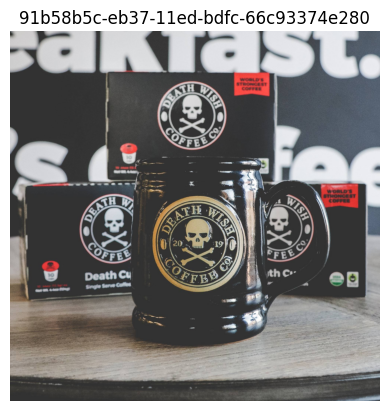

In [18]:
image.plot()

In [20]:
coords = texts[0].to_dict()['polygon']

[{'X': 7.615242066094652e-05, 'Y': -0.008726202882826328},
 {'X': 1.0012829303741455, 'Y': 1.1196392733836547e-05},
 {'X': 1.0, 'Y': 0.14702609181404114},
 {'X': -0.0012068271171301603, 'Y': 0.1382886916399002}]

In [ ]:
coords = 

In [59]:
with open('relevant_uuids.py', 'a') as file:
    file.write(f"'{image.name}',\n")

image = images[0]


In [5]:
labels = image.detect_text(Filters=TEXT_FILTERS)
text = '\n'.join([label.text for label in labels if label.kind == 'LINE'])
print(text)

GET 10% OFF YOUR
FIRST ORDER
Step
One
Foods
TM
physician formulated


In [56]:
print(text)

SMITHEY
COMPANY
Modern cookware with an old soul.
Hand-crafted to elevate your cooking experience.


In [9]:
labels[0].to_dict()

{'text': 'GET 10% OFF YOUR',
 'kind': 'LINE',
 'polygon': [{'X': 0.07585852593183517, 'Y': 0.073999784886837},
  {'X': 0.9111327528953552, 'Y': 0.073999784886837},
  {'X': 0.9111327528953552, 'Y': 0.13446220755577087},
  {'X': 0.07585852593183517, 'Y': 0.13446220755577087}],
 'confidence': 100.0}

In [21]:
df = pd.DataFrame([(label.text, label.geometry['BoundingBox']["Height"]) for label in labels if label.kind == 'LINE'], columns=['text', 'height'])
df

,text,height
0,GET 10% OFF YOUR,0.060462
1,FIRST ORDER,0.059570
2,Step,0.038374
3,One,0.062211
4,Foods,0.034180
5,TM,0.008789
6,physician formulated,0.067777


In [22]:
max_height = df.height.max()
df[df.height >= max_height*0.8]

,text,height
0,GET 10% OFF YOUR,0.060462
1,FIRST ORDER,0.059570
3,One,0.062211
6,physician formulated,0.067777


In [24]:
df.height.idxmax()

6

In [26]:
df

,text,height
0,GET 10% OFF YOUR,0.060462
1,FIRST ORDER,0.059570
2,Step,0.038374
3,One,0.062211
4,Foods,0.034180
5,TM,0.008789
6,physician formulated,0.067777


In [27]:
df.loc[df.height.idxmax(), 'text']

'physician formulated'

In [166]:
[label.text for label in labels]

['literally', 'changing', 'just', 'literally', 'changing', 'just']

In [160]:
text = ' '.join([label.text for label in labels if label.kind == 'LINE'])
text

'TEATIME'

In [144]:
with open('images_with_text.py', 'a') as file:
    file.write(f"'{image.name}',\n")

In [18]:
df = read_csv_from_s3("global/data/texts_2022.csv")

In [19]:
df

,Unnamed: 0,shop_id,account_id,ad_id,primary,description,title,industry
0,5,96,740587486140754,23849291873500023,[Visit our LA store and receive a free P.F. Ca...,[Our first store is officially open at ﻿﻿8402 ...,"[8402 MELROSE AVE, WEST HOLLYWOOD, CA!]",unknown
1,6,96,740587486140754,23849419902350023,[New Year Luxe. Free 2-Day Shipping On All Ord...,[],[We're feeling '22],unknown
2,7,96,740587486140754,23849453622440023,[Take 20% off all ﻿dresses for every occasion ...,[Take 20% off all dresses!],[The Dress Sale],unknown
3,8,96,740587486140754,23849453802350023,[Take 20% off all ﻿dresses for every occasion ...,[Take 20% off all dresses!],[],unknown
4,9,96,740587486140754,23849512241060023,[Our Anniversary Sale Starts Now! ﻿EXTRA 40% o...,[EXTRA 40% off sale styles],[Don't miss our biggest sale of the year!],unknown
...,...,...,...,...,...,...,...,...
16816,17173,74399413,29892839,6290453197161,[Summer full of colors 🤍☀️🌊],[],[],unknown
16817,17174,79497608,1786466174994988,23850247601380115,"[It's time for a coffee full of flavor, not su...",[Clean coffee should taste good],[Coconut Water Iced Coffee],unknown
16818,17175,79993181,213501581,6274482509344,[Fresh seasonal produce delivered to your door...,[],[],unknown
16819,17176,79993181,213501581,6275214193944,[Fresh vegetables! \n\nMin order $40\n\nView p...,[],[],unknown


In [5]:
df = read_csv_from_s3(s3_image.final_by_shop_df)

In [13]:
df.groupby(["shop_id"])["spend_USD"].sum().sort_values(ascending=False).head(30)

shop_id
99677322.0     2.539210e+06
16002430.0     1.113024e+06
3397559.0      8.316542e+05
268714.0       6.701079e+05
14486167.0     6.661253e+05
18600257.0     6.446170e+05
96659600.0     4.357669e+05
10080134.0     3.316777e+05
43247895.0     3.295536e+05
34237718.0     2.272429e+05
83029637.0     2.107841e+05
19505868.0     1.243176e+05
27227973.0     1.138900e+05
45867058.0     1.126442e+05
15433380.0     1.101739e+05
22502944.0     1.068726e+05
46167900.0     1.068479e+05
46317801.0     1.030681e+05
98938809.0     1.004413e+05
28932952.0     8.275415e+04
10248339.0     7.428907e+04
39346644.0     7.385454e+04
159350.0       7.352848e+04
42787782.0     7.268251e+04
43375757.0     6.921475e+04
39106511.0     6.697516e+04
40896545.0     6.644792e+04
100474898.0    6.257207e+04
38955025.0     6.037485e+04
24640760.0     6.036473e+04
Name: spend_USD, dtype: float64

In [15]:
urls = db.query(Image.url).filter(func.random() > 0.99, Image.source == "facebook").limit(100).all()
urls = [row.url for row in urls]

In [16]:
imgs = []
for url in urls:
    img = download_image(img_url=url, convert_to_rgb=True)
    if img is not None:
        imgs.append(img)
len(imgs)

0

In [13]:
plot_list_of_images(imgs)

<Figure size 2000x0 with 0 Axes>

In [2]:
shop_ids = db.query(Image.shop_id).filter(Image.source == "facebook").distinct().all()
shop_ids = pd.Series([row.shop_id for row in shop_ids])

In [3]:
df = ping_image_urls_and_ad_performance_per_shop(db=db, shop_id=shop_ids[0])

In [2]:
rekognition_client = boto3.client("rekognition")
img_path = f'{os.getenv("GLOBAL_PATH_TO_REPO")}/data/bernardo.png'
with open(img_path, "rb") as file:
    img_bytes = file.read()
img = cv2.imread(img_path)
img = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB).astype(np.uint8)

In [3]:
rkgn_img = RekognitionImage(
    img_bytes=img_bytes,
    img_name="bernardo",
    rekognition_client=rekognition_client,
    minboundingbox_height=0.05,
)
labels = rkgn_img.detect_text()
labels

2023-05-04 15:28:33.086 | INFO     | src.image_analysis.rekognition.RekognitionImage:detect_text:129 - Found %s texts in %s.


In [4]:
set([label.text for label in labels])

{'2', 'T'}

In [32]:
label = labels[4]
label.text

'ETIHAD'

In [8]:
label.geometry

{'BoundingBox': {'Width': 0.027947282418608665,
  'Height': 0.021162644028663635,
  'Left': 0.8400550484657288,
  'Top': 0.4480012059211731},
 'Polygon': [{'X': 0.8400550484657288, 'Y': 0.4564096927642822},
  {'X': 0.8634105920791626, 'Y': 0.4480012059211731},
  {'X': 0.8680023550987244, 'Y': 0.4607553482055664},
  {'X': 0.8446468114852905, 'Y': 0.46916383504867554}]}

In [9]:
img.shape

(1707, 2560, 3)

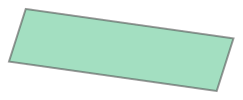

In [33]:
height, width, _ = img.shape
relative_coords = label.to_dict()["polygon"]
relative_coords = [tuple(coord.values()) for coord in relative_coords]
apsolute_coords = [(x * width, y * height) for x, y in relative_coords]
pol = Polygon(apsolute_coords)
pol

In [34]:
apsolute_coords

[(1100.8665466308594, 724.9721450507641),
 (1309.6876525878906, 695.3755045831203),
 (1326.5451049804688, 748.257993042469),
 (1117.7239990234375, 777.8546335101128)]

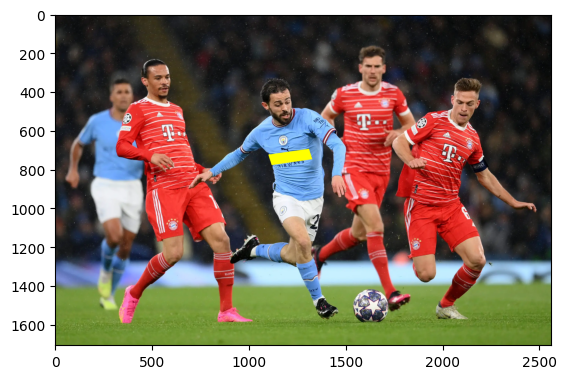

In [37]:
overlay = img.copy()
int_coords = lambda x: np.array(x).round().astype(np.int32)
exterior = [int_coords(pol.exterior.coords)]
cv2.fillPoly(overlay, exterior, color=(255, 255, 0))
plt.imshow(overlay)

In [15]:
int_coords = lambda x: np.array(x).round().astype(np.int32)
exterior = [int_coords(pol.exterior.coords)]
overlay = img.copy()
# alpha = 0.5
# cv2.fillPoly(overlay, exterior, color=(255, 255, 255))
# cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
# cv2.imshow("Polygon", img)

In [16]:
exterior

[array([], shape=(0, 2), dtype=int32)]